In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


2025-03-19 12:37:46.566393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 12:37:46.627913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742398666.668096   34673 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742398666.683707   34673 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 12:37:46.748366: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-03-19 12:37:52--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2025-03-19 12:37:52 (4.74 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
df = dataset
df["sex"] = pd.factorize(df["sex"])[0]
df["region"] = pd.factorize(df["region"])[0]
df["smoker"] = pd.factorize(df["smoker"])[0]
df.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,1,31.0,3,1,2,10600.55
1334,18,0,31.9,0,1,3,2205.98
1335,18,0,36.9,0,1,1,1629.83
1336,21,0,25.8,0,1,0,2007.95
1337,61,0,29.1,0,0,2,29141.36


In [ ]:
test_df = df.sample(frac=0.2)
train_df = df[~df.isin(test_df)].dropna()

print("\nTest:\n", test_df.head(), "\nTest Size:", len(test_df))
print("\nTrain:\n",train_df.head(), "\nTrain Size:", len(train_df))


Test:
       age  sex   bmi  children  smoker  region  expenses
1133   52    0  18.3         0       1       2   9991.04
475    61    1  28.3         1       0       2  28868.66
1153   35    0  35.8         1       1       2   5630.46
707    49    1  28.7         3       1       2  10264.44
409    32    1  30.0         1       1       1   4074.45 
Test Size: 268

Train:
     age  sex   bmi  children  smoker  region  expenses
0  19.0  0.0  27.9       0.0     0.0     0.0  16884.92
2  28.0  1.0  33.0       3.0     1.0     1.0   4449.46
4  32.0  1.0  28.9       0.0     1.0     2.0   3866.86
5  31.0  0.0  25.7       0.0     1.0     1.0   3756.62
6  46.0  0.0  33.4       1.0     1.0     1.0   8240.59 
Train Size: 1070


In [5]:
train_labels = train_df.pop("expenses")
test_labels = test_df.pop("expenses")

print("#################  TRAIN  ##################")
print(train_labels.head(), "\n")
print(train_df.head())

print("\n#################  TEST  ##################")
print(test_labels.head(), "\n")
print(test_df.head())

train_dataset = train_df
test_dataset = test_df

#################  TRAIN  ##################
0    16884.92
2     4449.46
4     3866.86
5     3756.62
6     8240.59
Name: expenses, dtype: float64 

    age  sex   bmi  children  smoker  region
0  19.0  0.0  27.9       0.0     0.0     0.0
2  28.0  1.0  33.0       3.0     1.0     1.0
4  32.0  1.0  28.9       0.0     1.0     2.0
5  31.0  0.0  25.7       0.0     1.0     1.0
6  46.0  0.0  33.4       1.0     1.0     1.0

#################  TEST  ##################
1133     9991.04
475     28868.66
1153     5630.46
707     10264.44
409      4074.45
Name: expenses, dtype: float64 

      age  sex   bmi  children  smoker  region
1133   52    0  18.3         0       1       2
475    61    1  28.3         1       0       2
1153   35    0  35.8         1       1       2
707    49    1  28.7         3       1       2
409    32    1  30.0         1       1       1


In [6]:
input_array = np.array(train_df)
input_shape = input_array.shape[1:] 

normalizer = layers.Normalization(axis=-1)
normalizer.adapt(input_array)

model = keras.Sequential([
    keras.Input(shape=input_shape), 
    normalizer,
    layers.Dense(16, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dropout(.2),
    layers.Dense(1)
])

model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.09),
    loss='mae',
    metrics=['mae', 'mse']
)

model.summary()

I0000 00:00:1742398673.725617   34673 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3542 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 6)              │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198 (796.00 B)

 Trainable params: 185 (740.00 B)

 Non-trainable params: 13 (56.00 B)

In [7]:
history = model.fit(
    train_dataset,
    train_labels,
    epochs=100,
    validation_split=0.5 
)

Epoch 1/100


I0000 00:00:1742398677.183929   34936 service.cc:148] XLA service 0x7fbaa8015b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742398677.184044   34936 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-03-19 12:37:57.224360: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742398677.444102   34936 cuda_dnn.cc:529] Loaded cuDNN version 90300


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12910.0938 - mae: 12910.0938 - mse: 309315456.0000

I0000 00:00:1742398679.325189   34936 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - loss: 12953.9717 - mae: 12953.9717 - mse: 310890112.0000 - val_loss: 12927.5703 - val_mae: 12927.5703 - val_mse: 312154304.0000
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 12830.9258 - mae: 12830.9258 - mse: 323984000.0000 - val_loss: 10414.9922 - val_mae: 10414.9922 - val_mse: 247894304.0000
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9280.7227 - mae: 9280.7227 - mse: 201750624.0000 - val_loss: 6662.7734 - val_mae: 6662.7734 - val_mse: 130704736.0000
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6312.4922 - mae: 6312.4922 - mse: 107633360.0000 - val_loss: 4629.0415 - val_mae: 4629.0415 - val_mse: 76488616.0000
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5681.9004 - mae: 5681.9004 - mse: 91528120.0000 - val_loss: 3675.1292 - val_mae: 3675.1292 - val_mse: 36957212.0000
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4473.4155 - mae: 4473.4155 - mse: 55882880.0000 - val_lo

9/9 - 1s - 62ms/step - loss: 3002.7532 - mae: 3002.7532 - mse: 33045354.0000
Testing set Mean Abs Error: 3002.75 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


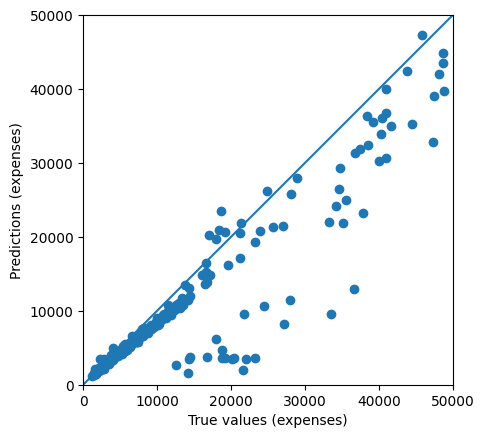

In [8]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
